In [7]:
# Install and import
!pip install --quiet --no-deps git+https://github.com/asztr/LombScargle.git

import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import LombScargle

  Preparing metadata (setup.py) ... done


**Basic Usage Example**

In [2]:
# Define example time series with single frequency = 5
t = torch.linspace(0, 10.0, 100) #timestamps
y = torch.sin(2*math.pi*5.0*t) #values

# Select frequencies to evaluate
freqs = torch.linspace(1e-5, 10.0, 100)

# Compute the normalized spectrum
ls = LombScargle.LombScargle(freqs)
P = ls(t, y, fap=True, norm=True)  # [1, 100] array of power values

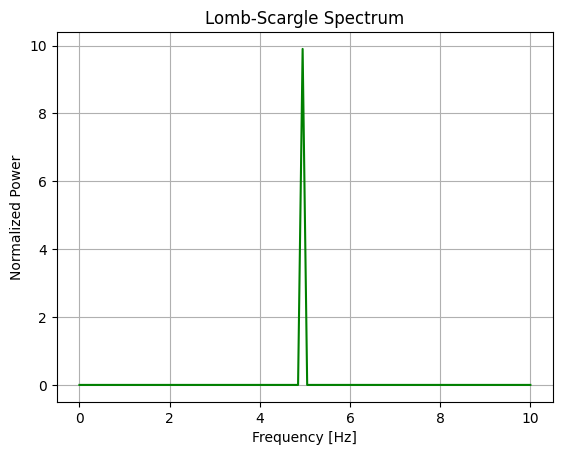

In [3]:
# Plot the spectrum
plt.plot(freqs, P[0].detach().numpy(), c="g")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized Power")
plt.title("Lomb-Scargle Spectrum")
plt.grid(True)
plt.show()

**Basic Example with Batching and Masking**

In [4]:
# Define example time series with single frequency = 5 (batch_size = 1)
t = torch.linspace(0, 10.0, 100)[None, :] #timestamps
y = torch.sin(2*math.pi*5.0*t) #values
mask = (torch.rand_like(t) > 0.4).int() #binary mask with 40% zeros

# Select frequencies to evaluate
freqs = torch.linspace(1e-5, 10.0, 100)

# Compute the normalized spectrum
ls = LombScargle.LombScargle(freqs)
P = ls(t, y, mask=mask, fap=True, norm=True)  # [1, 100] array of power values

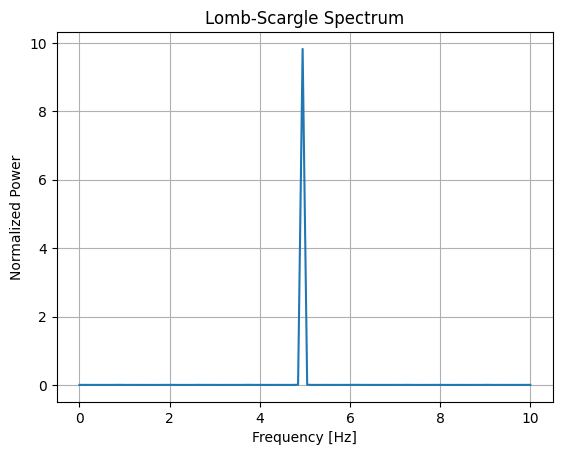

In [5]:
# Plot the spectrum
plt.plot(freqs, P[0].detach().numpy())
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized Power")
plt.title("Lomb-Scargle Spectrum")
plt.grid(True)
plt.show()

# Comparison of FFT and Lomb-Scargle
Here we define a dataset of time series with 75% missing data and compare the performance of FFT+Interpolation vs Lomb-Scargle in identifying the lead frequency.

**Create Dataset of Sines**

In [8]:
def generate_timeseries(t, amps, freqs, phases, noise=0.0):
    ft = np.zeros_like(t)
    for amp, freq, phase in zip(amps, freqs, phases):
        ft += amp * np.sin(2*np.pi*freq * t + phase)
    ft += noise * np.random.randn(len(t))
    return ft

def generate_timeseries_dataset1(ntsteps, t_max, nsamples, amps=[1.0], freqs_mu=[1.0], freqs_w=[1.0], noise=0.0):
    np.random.seed(0)
    mu, w, amps = np.array(freqs_mu), np.array(freqs_w), np.array(amps)
    ts, fts, freqs, freq_amps = [], [], [], []
    for its in range(nsamples):
        t = np.linspace(0.0, t_max, ntsteps)
        gen_freqs = np.random.beta(2,2,size=len(mu)) * w + (mu - w / 2.0)
        gen_phases = np.random.normal(size=len(freqs_mu))
        ft = generate_timeseries(t, amps, gen_freqs, gen_phases, noise=noise)
        ts.append(t)
        fts.append(ft)
        freqs.append(gen_freqs)
        freq_amps.append(amps)
    return np.array(ts), np.array(fts), np.array(freqs), np.array(freq_amps)

def define_mask(x, false_rate=0.1):
    mask = np.ones_like(x, dtype=bool)
    num_false = int(false_rate*mask.size)
    idxs_false = np.random.choice(mask.size, num_false, replace=False)
    mask.ravel()[idxs_false] = False
    return mask

ntsteps, t_max, nsamples = 100, 10.0, 1000
noise_rate, false_rate = 0.0, 0.75
amps_arr = [[1.0], [0.5, 1.0], [0.5, 1.0, 1.5]]
freqs_mu_arr = [[1.0], [1.0, 2.0], [1.0, 2.0, 3.0]]
freqs_w_arr = [[1.0], [1.0, 1.5], [1.0, 1.0, 1.5]]

data = { "ts_arr":[], "fts_arr":[], "mask_arr":[], "freqs_arr":[], "famps_arr":[] }
for amps, freqs_mu, freqs_w in zip(amps_arr, freqs_mu_arr, freqs_w_arr):
    ts, fts, freqs, famps = generate_timeseries_dataset1(ntsteps=ntsteps, t_max=t_max, nsamples=nsamples, amps=amps, freqs_mu=freqs_mu, freqs_w=freqs_w, noise=noise_rate)
    mask = define_mask(fts, false_rate=false_rate)
    data["ts_arr"].append(ts)
    data["fts_arr"].append(fts)
    data["mask_arr"].append(mask)
    data["freqs_arr"].append(freqs)
    data["famps_arr"].append(famps)
data["ts_arr"] = np.moveaxis(data["ts_arr"], 0, 1)
data["fts_arr"] = np.moveaxis(data["fts_arr"], 0, 1)
data["mask_arr"] = np.moveaxis(data["mask_arr"], 0, 1)

ifreq = 0
ts = data["ts_arr"][:, ifreq, :]
fts = data["fts_arr"][:, ifreq, :]
freqs = data["freqs_arr"][ifreq]
mask = data["mask_arr"][:, ifreq, :]


**Compute FFT and LS**

In [ ]:
def np2t(x):
    return torch.from_numpy(x).float()

def FFT(ts, fts):
    dt = ts[0][1] - ts[0][0]
    npts = fts.shape[-1]
    freqs = np.fft.fftfreq(npts, d=dt)
    Famps = np.fft.fft(fts)
    Fabs = np.abs(Famps)
    return { "freqs":freqs, "freqs+":freqs[:npts//2], "Fabs":Fabs, "Fabs+":Fabs[:, :npts//2], 'ps':Fabs[:, :npts//2]**2/npts }

def LS(ts, fts, freqs=None, eps=1e-5, mask=None, fap=True, norm=True):
    if freqs is None:
        freqs = LombScargle.compute_freqs(ts[0])
        freqs[0] = torch.clip(freqs[0], eps, None)
    ls_torch = LombScargle.LombScargle(freqs)
    power = ls_torch(np2t(ts), np2t(fts), mask=mask, fap=fap, norm=norm).numpy()
    return { "freqs+":freqs, "ps":power }

def leadfreqs(freqs, spectra):
    return freqs[np.argmax(spectra, axis=1)]

fts_masked = fts.copy()
fts_masked[~mask] = np.nan
fts_filled = pd.DataFrame(fts_masked).interpolate(method='linear', axis=1).fillna(method='bfill', axis=1).values

# Compute spectral estimators
ls = LS(ts, fts, fap=False, norm=True)
ls_masked = LS(ts, fts, mask=np2t(mask), fap=False, norm=True)
ls_fap = LS(ts, fts, mask=np2t(mask), fap=True, norm=True)
fft = FFT(ts, fts)
fft_filled = FFT(ts, fts_filled)


**Plot the histograms of lead frequencies**

Figure: Density of leading frequencies for FFT and LombScargle (LS) on a synthetic sine dataset. (Left) Fully observed time series. (Right) Time series with 75% missing data. The interpolation required by FFT significantly distorts the spectral distribution, whereas LS better preserves the original frequency structure.

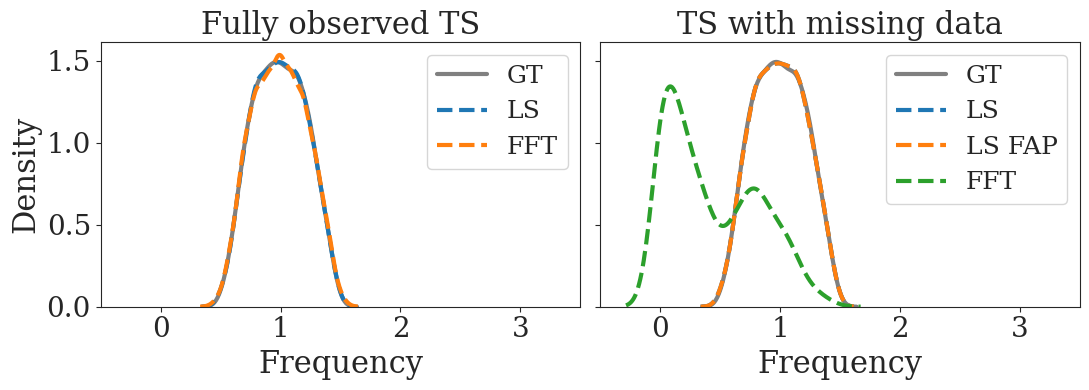

In [10]:
sns.set_style("ticks", {'font.family':'serif', 'font.serif':'Times New Roman'})
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True)
sns.set_palette("Set1")

sns.kdeplot(data["freqs_arr"][ifreq][:, np.argmax(freqs_mu_arr[ifreq])], label='GT', linewidth=3, ax=axes[0], color='gray')
sns.kdeplot(leadfreqs(ls["freqs+"], ls["ps"]), label='LS', linewidth=3, ax=axes[0], linestyle='--')
sns.kdeplot(leadfreqs(fft["freqs+"], fft["ps"]), label='FFT', linewidth=3, ax=axes[0], linestyle='--')
axes[0].set_title("Fully observed TS", fontsize=22)

sns.kdeplot(data["freqs_arr"][ifreq][:, np.argmax(freqs_mu_arr[ifreq])], label='GT', linewidth=3, ax=axes[1], color='gray')
sns.kdeplot(leadfreqs(ls_masked["freqs+"], ls_masked["ps"]), label='LS', linewidth=3, ax=axes[1], linestyle='--')
sns.kdeplot(leadfreqs(ls_fap["freqs+"], ls_fap["ps"]), label='LS FAP', linewidth=3, ax=axes[1], linestyle='--')
sns.kdeplot(leadfreqs(fft_filled["freqs+"], fft_filled["ps"]), label='FFT', linewidth=3, ax=axes[1], linestyle='--')
axes[1].set_title("TS with missing data", fontsize=22)

for ax in axes:
    ax.set_xlabel("Frequency", fontsize=22)
    ax.set_ylabel("Density", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=18)
    ax.set_xlim(-0.5, 3.5)

plt.tight_layout()
plt.show()
